### Data Preparation and Text Encoding

In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sentence_transformers import SentenceTransformer

from deepctr.models import DeepFM

/home/niranjan/miniconda3/envs/deepctr/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preprocessed_inter_df = pd.read_csv("./MealRec/preprocessed_user_recipe.csv")
preprocessed_inter_df.info()
preprocessed_inter_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151148 entries, 0 to 151147
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    151148 non-null  int64
 1   recipe_id  151148 non-null  int64
 2   rating     151148 non-null  int64
 3   year       151148 non-null  int64
 4   month      151148 non-null  int64
 5   day        151148 non-null  int64
 6   hour       151148 non-null  int64
dtypes: int64(7)
memory usage: 8.1 MB


,user_id,recipe_id,rating,year,month,day,hour
0,39,61727,4,2001,3,26,7
1,39,7612,5,2004,8,2,16
2,39,12009,4,2001,2,28,10
3,39,88185,5,2009,5,18,14
4,39,24445,5,2015,5,7,15


In [3]:
preprocessed_recipe_df = pd.read_csv("./MealRec/preprocessed_recipe.csv")
preprocessed_recipe_df.info()
preprocessed_recipe_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7280 entries, 0 to 7279
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recipe_id           7280 non-null   int64  
 1   recipe_name         7280 non-null   object 
 2   review_nums         7280 non-null   int64  
 3   category            7280 non-null   object 
 4   aver_rate           7280 non-null   float64
 5   ingredients         7280 non-null   object 
 6   cooking_directions  7280 non-null   object 
 7   nutritions          7280 non-null   object 
 8   tags                7278 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 512.0+ KB


,recipe_id,recipe_name,review_nums,category,aver_rate,ingredients,cooking_directions,nutritions,tags
0,6698,Mom's Zucchini Bread,9355,appetizer,4.754207,purpose flour salt baking soda baking powder g...,directions u prep n20 ncook n1 h nready n1 h 4...,u niacin u hascompletedata true u name u niaci...,north american breads easy beginner cook inexp...
1,6709,Zucchini Walnut Bread,58,appetizer,4.478873,chopped walnuts eggs white sugar vegetable oil...,directions u whisk together flour baking soda ...,u niacin u hascompletedata true u name u niaci...,weeknight breads fruit vegetables kid friendly...
2,6725,Honey Wheat Bread I,2054,appetizer,4.766846,rapid rise yeast white sugar warm water 110 de...,directions u prep n25 ncook n35 nready n2 h 30...,u niacin u hascompletedata true u name u niaci...,healthy breads dietary low cholesterol healthy...
3,6730,Chocolate Chip Orange Zucchini Bread,503,dessert,4.674833,eggs white sugar vegetable oil vanilla extract...,directions u sift together flour baking powder...,u niacin u hascompletedata true u name u niaci...,large groups healthy breads kid friendly dieta...
4,6732,Chocolate Chip Pumpkin Bread,866,dessert,4.718112,white sugar pumpkin puree vegetable oil water ...,directions u prep n30 ncook n1 h nready n1 h 3...,u niacin u hascompletedata true u name u niaci...,breads fall winter seasonal quick breads 4 hou...


In [4]:
input_data_df = pd.merge(preprocessed_inter_df, preprocessed_recipe_df, how="left", on="recipe_id")
input_data_df.info()
input_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151148 entries, 0 to 151147
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             151148 non-null  int64  
 1   recipe_id           151148 non-null  int64  
 2   rating              151148 non-null  int64  
 3   year                151148 non-null  int64  
 4   month               151148 non-null  int64  
 5   day                 151148 non-null  int64  
 6   hour                151148 non-null  int64  
 7   recipe_name         151148 non-null  object 
 8   review_nums         151148 non-null  int64  
 9   category            151148 non-null  object 
 10  aver_rate           151148 non-null  float64
 11  ingredients         151148 non-null  object 
 12  cooking_directions  151148 non-null  object 
 13  nutritions          151148 non-null  object 
 14  tags                151120 non-null  object 
dtypes: float64(1), int64(8), object(6)

,user_id,recipe_id,rating,year,month,day,hour,recipe_name,review_nums,category,aver_rate,ingredients,cooking_directions,nutritions,tags
0,39,61727,4,2001,3,26,7,Ten Minute Enchilada Sauce,2443,main-dish,4.439774,vegetable oil self rising flour new mexico tom...,directions u prep n10 ncook n15 nready n25 nhe...,u niacin u hascompletedata true u name u niaci...,15 minutes less north american sauces condimen...
1,39,7612,5,2004,8,2,16,Chocolate Lovers' Favorite Cake,848,dessert,4.683846,devil food cake mix instant chocolate pudding ...,directions u prep n30 ncook n1 h nready n2 h n...,u niacin u hascompletedata false u name u niac...,large groups desserts oven cakes chocolate die...
2,39,12009,4,2001,2,28,10,Cajun Chicken Pasta,4573,main-dish,4.676716,linguine pasta boneless skinless chicken breas...,directions u prep n15 ncook n15 nready n30 nbr...,u niacin u hascompletedata false u name u niac...,30 minutes less north american main dish pasta...
3,39,88185,5,2009,5,18,14,Sopapilla Cheesecake,235,dessert,4.793919,cream cheese white sugar vanilla extract refri...,directions u prep n15 ncook n30 nready n45 npr...,u niacin u hascompletedata false u name u niac...,60 minutes less north american desserts eggs d...
4,39,24445,5,2015,5,7,15,Chewy Chocolate Chip Oatmeal Cookies,21731,dessert,4.554303,butter packed light brown sugar white sugar eg...,directions u prep n15 ncook n12 nready n55 npr...,u niacin u hascompletedata true u name u niaci...,30 minutes less large groups breakfast lunch s...


### Text Encoding

In [5]:
soup_columns = ["recipe_name", "ingredients", "cooking_directions", "nutritions", "tags"]
input_data_df[soup_columns] = input_data_df[soup_columns].astype(str)

In [6]:
input_data_df["soup"] = input_data_df.apply(lambda row: ' '.join(row[column] for column in soup_columns), axis=1)

In [7]:
input_data_df.drop(soup_columns, axis=1, inplace=True)
input_data_df.head()

,user_id,recipe_id,rating,year,month,day,hour,review_nums,category,aver_rate,soup
0,39,61727,4,2001,3,26,7,2443,main-dish,4.439774,Ten Minute Enchilada Sauce vegetable oil self ...
1,39,7612,5,2004,8,2,16,848,dessert,4.683846,Chocolate Lovers' Favorite Cake devil food cak...
2,39,12009,4,2001,2,28,10,4573,main-dish,4.676716,Cajun Chicken Pasta linguine pasta boneless sk...
3,39,88185,5,2009,5,18,14,235,dessert,4.793919,Sopapilla Cheesecake cream cheese white sugar ...
4,39,24445,5,2015,5,7,15,21731,dessert,4.554303,Chewy Chocolate Chip Oatmeal Cookies butter pa...


In [8]:
input_data_df["rating"].value_counts()

5    101162
4     49986
Name: rating, dtype: int64

In [9]:
input_data_df["rating_binary"] = input_data_df["rating"].apply(lambda x: 1 if x == 5 else 0)
input_data_df["rating_binary"].value_counts()

1    101162
0     49986
Name: rating_binary, dtype: int64

In [10]:
input_data_df["category"].value_counts()

main-dish    69629
dessert      46713
appetizer    34806
Name: category, dtype: int64

### Feature Preparation

In [11]:
input_data_df.columns

Index(['user_id', 'recipe_id', 'rating', 'year', 'month', 'day', 'hour',
       'review_nums', 'category', 'aver_rate', 'soup', 'rating_binary'],
      dtype='object')

In [12]:
sparse_features = ['user_id', 'recipe_id', 'year', 'month', 'day', 'hour', 'review_nums', 'category']
dense_features = ['aver_rate'] + ['S' + str(i) for i in range(384)]
target = ['rating']
binary_target = ['rating_binary']
len(sparse_features), len(dense_features)

(8, 385)

In [13]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(input_data_df["soup"])

In [14]:
embeddings.shape

(151148, 384)

In [15]:
embedding_df = pd.DataFrame(embeddings)
new_column_names = ['S' + str(column_name) for column_name in embedding_df.columns]
embedding_df.columns = new_column_names
embedding_df.head()

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S374,S375,S376,S377,S378,S379,S380,S381,S382,S383
0,-0.111436,-0.040948,-0.057941,0.015953,-0.018936,0.037412,0.012590,0.001398,-0.048894,-0.101665,...,0.024887,-0.010257,-0.010988,0.010452,0.082712,-0.033739,-0.016636,0.003499,-0.023667,-0.027235
1,-0.036413,-0.053848,0.003229,0.038018,-0.062606,0.078616,0.064194,-0.035521,-0.059117,-0.072094,...,0.010587,-0.045071,-0.045402,-0.001529,0.069227,-0.009304,0.073575,-0.059087,-0.035748,-0.034407
2,-0.075072,-0.074056,0.034874,0.031111,-0.086727,0.025177,-0.000885,-0.035395,0.007340,-0.109709,...,0.009217,0.050782,0.061283,0.059879,0.058811,-0.024088,0.007671,0.005238,-0.024675,-0.019433
3,-0.035020,-0.061098,-0.039660,0.004993,-0.069157,0.049868,-0.008119,0.005810,-0.069115,-0.083739,...,0.005485,-0.043433,-0.044295,0.013488,0.046622,0.013558,0.044556,-0.071943,0.017962,-0.065143
4,-0.041591,-0.039967,-0.011735,0.017094,-0.039102,-0.018431,0.084702,-0.031791,-0.069285,-0.056987,...,0.003406,-0.069302,-0.035556,0.004992,0.071154,-0.025822,0.066152,-0.057682,-0.047094,-0.072154


In [16]:
embedding_df[new_column_names] = embedding_df[new_column_names].astype('float64')
embedding_df.dtypes

S0      float64
S1      float64
S2      float64
S3      float64
S4      float64
         ...   
S379    float64
S380    float64
S381    float64
S382    float64
S383    float64
Length: 384, dtype: object

In [17]:
input_data_df.dtypes

user_id            int64
recipe_id          int64
rating             int64
year               int64
month              int64
day                int64
hour               int64
review_nums        int64
category          object
aver_rate        float64
soup              object
rating_binary      int64
dtype: object

In [18]:
input_data_df = pd.concat([input_data_df, embedding_df], axis=1)
input_data_df.head(2)

,user_id,recipe_id,rating,year,month,day,hour,review_nums,category,aver_rate,...,S374,S375,S376,S377,S378,S379,S380,S381,S382,S383
0,39,61727,4,2001,3,26,7,2443,main-dish,4.439774,...,0.024887,-0.010257,-0.010988,0.010452,0.082712,-0.033739,-0.016636,0.003499,-0.023667,-0.027235
1,39,7612,5,2004,8,2,16,848,dessert,4.683846,...,0.010587,-0.045071,-0.045402,-0.001529,0.069227,-0.009304,0.073575,-0.059087,-0.035748,-0.034407


In [19]:
# processing the sparse features
for feat in sparse_features:
    lbe = LabelEncoder()
    input_data_df[feat] = lbe.fit_transform(input_data_df[feat])
input_data_df.head()

,user_id,recipe_id,rating,year,month,day,hour,review_nums,category,aver_rate,...,S374,S375,S376,S377,S378,S379,S380,S381,S382,S383
0,0,4262,4,1,2,25,7,1071,2,4.439774,...,0.024887,-0.010257,-0.010988,0.010452,0.082712,-0.033739,-0.016636,0.003499,-0.023667,-0.027235
1,0,101,5,4,7,1,16,708,1,4.683846,...,0.010587,-0.045071,-0.045402,-0.001529,0.069227,-0.009304,0.073575,-0.059087,-0.035748,-0.034407
2,0,1012,4,1,1,27,10,1157,2,4.676716,...,0.009217,0.050782,0.061283,0.059879,0.058811,-0.024088,0.007671,0.005238,-0.024675,-0.019433
3,0,4924,5,9,4,17,14,230,1,4.793919,...,0.005485,-0.043433,-0.044295,0.013488,0.046622,0.013558,0.044556,-0.071943,0.017962,-0.065143
4,0,3170,5,15,4,6,15,1223,1,4.554303,...,0.003406,-0.069302,-0.035556,0.004992,0.071154,-0.025822,0.066152,-0.057682,-0.047094,-0.072154


In [20]:
input_data_df["rating"].value_counts()

5    101162
4     49986
Name: rating, dtype: int64

In [21]:
mms = MinMaxScaler(feature_range=(0, 1))
input_data_df[dense_features] = mms.fit_transform(input_data_df[dense_features])

In [22]:
input_data_df["S0"]

0         0.331661
1         0.658547
2         0.490104
3         0.664616
4         0.635984
            ...   
151143    0.328784
151144    0.560027
151145    0.571579
151146    0.458344
151147    0.269763
Name: S0, Length: 151148, dtype: float64

In [23]:
input_data_df["S1"].dtypes

dtype('float64')

In [24]:
fixlen_feature_columns = [SparseFeat(feat, 
                                     vocabulary_size=input_data_df[feat].max() + 1, 
                                     embedding_dim=8)
                            for feat in sparse_features]

fixlen_feature_columns += [DenseFeat(feat, 1) for feat in dense_features]

In [25]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
len(feature_names), feature_names

(393,
 ['user_id',
  'recipe_id',
  'year',
  'month',
  'day',
  'hour',
  'review_nums',
  'category',
  'aver_rate',
  'S0',
  'S1',
  'S2',
  'S3',
  'S4',
  'S5',
  'S6',
  'S7',
  'S8',
  'S9',
  'S10',
  'S11',
  'S12',
  'S13',
  'S14',
  'S15',
  'S16',
  'S17',
  'S18',
  'S19',
  'S20',
  'S21',
  'S22',
  'S23',
  'S24',
  'S25',
  'S26',
  'S27',
  'S28',
  'S29',
  'S30',
  'S31',
  'S32',
  'S33',
  'S34',
  'S35',
  'S36',
  'S37',
  'S38',
  'S39',
  'S40',
  'S41',
  'S42',
  'S43',
  'S44',
  'S45',
  'S46',
  'S47',
  'S48',
  'S49',
  'S50',
  'S51',
  'S52',
  'S53',
  'S54',
  'S55',
  'S56',
  'S57',
  'S58',
  'S59',
  'S60',
  'S61',
  'S62',
  'S63',
  'S64',
  'S65',
  'S66',
  'S67',
  'S68',
  'S69',
  'S70',
  'S71',
  'S72',
  'S73',
  'S74',
  'S75',
  'S76',
  'S77',
  'S78',
  'S79',
  'S80',
  'S81',
  'S82',
  'S83',
  'S84',
  'S85',
  'S86',
  'S87',
  'S88',
  'S89',
  'S90',
  'S91',
  'S92',
  'S93',
  'S94',
  'S95',
  'S96',
  'S97',
  'S98',

In [26]:
train, test = train_test_split(input_data_df, test_size=0.2, random_state=2020)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

In [27]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120918 entries, 73154 to 41824
Columns: 396 entries, user_id to S383
dtypes: float64(385), int64(10), object(1)
memory usage: 366.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30230 entries, 50307 to 731
Columns: 396 entries, user_id to S383
dtypes: float64(385), int64(10), object(1)
memory usage: 91.6+ MB


(None, None)

In [28]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

In [29]:
EPOCHS = 50
BATCH_SIZE = 256

In [30]:
len(train_model_input["recipe_id"]), len(test_model_input["recipe_id"]), type(train_model_input["recipe_id"])

(120918, 30230, pandas.core.series.Series)

In [31]:
history = model.fit(train_model_input, 
                    train[binary_target].values, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2, 
                    validation_split=0.2, )

Epoch 1/50
378/378 - 9s - loss: 0.6001 - binary_crossentropy: 0.5997 - val_loss: 0.5704 - val_binary_crossentropy: 0.5696
Epoch 2/50
378/378 - 4s - loss: 0.5560 - binary_crossentropy: 0.5548 - val_loss: 0.5710 - val_binary_crossentropy: 0.5695
Epoch 3/50
378/378 - 4s - loss: 0.5440 - binary_crossentropy: 0.5421 - val_loss: 0.5794 - val_binary_crossentropy: 0.5771
Epoch 4/50
378/378 - 4s - loss: 0.5371 - binary_crossentropy: 0.5344 - val_loss: 0.5849 - val_binary_crossentropy: 0.5819
Epoch 5/50
378/378 - 4s - loss: 0.5313 - binary_crossentropy: 0.5278 - val_loss: 0.5830 - val_binary_crossentropy: 0.5792
Epoch 6/50
378/378 - 4s - loss: 0.5252 - binary_crossentropy: 0.5210 - val_loss: 0.6011 - val_binary_crossentropy: 0.5965
Epoch 7/50
378/378 - 4s - loss: 0.5202 - binary_crossentropy: 0.5152 - val_loss: 0.5930 - val_binary_crossentropy: 0.5877
Epoch 8/50
378/378 - 4s - loss: 0.5139 - binary_crossentropy: 0.5083 - val_loss: 0.5984 - val_binary_crossentropy: 0.5925
Epoch 9/50
378/378 - 4s 

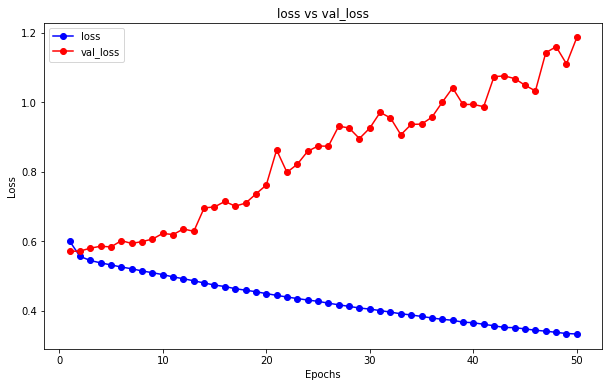

In [32]:
import matplotlib.pyplot as plt
# Extract loss and validation loss values
def plot_history(history, train_metric: str, val_metric: str):
    history_dict = history.history

    loss = history_dict[train_metric]
    val_loss = history_dict[val_metric]
    # Create an array with epoch numbers
    epochs = range(1, len(loss) + 1)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label=train_metric)
    plt.plot(epochs, val_loss, 'ro-', label=val_metric)
    plt.title(f'{train_metric} vs {val_metric}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history, "loss", "val_loss")

In [33]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(test[binary_target].values, pred_ans), 4))

test MSE 0.2652


### Manual Evaluation

In [40]:
ground_truth = test[binary_target].values
prediction = pred_ans
type(ground_truth), type(prediction)

(numpy.ndarray, numpy.ndarray)

In [41]:
import numpy as np
indices = np.random.choice(30230, size=10, replace=False)
sample_array1 = ground_truth[indices]
sample_array2 = prediction[indices]

In [42]:
df = pd.DataFrame({'truth': sample_array1.flatten(), 'pred': sample_array2.flatten()})
df['diff'] = np.abs(df['truth'] - df['pred'])
df


,truth,pred,diff
0,1,0.210931,0.789069
1,1,0.875345,0.124655
2,1,0.806425,0.193575
3,0,0.355590,0.355590
4,1,0.977633,0.022367
5,1,0.999773,0.000227
6,1,0.002225,0.997775
7,1,0.355923,0.644077
8,0,0.212040,0.212040
9,1,0.766470,0.233530
